In [1]:
import pandas as pd
import numpy as np

In [45]:
raw = pd.read_csv('../data/final_df_with_target.csv').rename(columns={'POLICY3_target': 'target'})
smote = pd.read_csv('../data/df_smote_with_target.csv').rename(columns={'POLICY3_target': 'target'})
print(raw.info())
print(smote.info())
print(smote['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 85 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype 
---  ------                                                                                                                                          --------------  ----- 
 0   HR5_No opinion                                                                                                                                  1211 non-null   int64 
 1   HR5_Somewhat dissatisfied                                                                                                                       1211 non-null   int64 
 2   HR5_Somewhat satisfied                                                                                                                          1211 non-null   int64 
 3   HR5_Very dissatisfied       

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2 as chi2_sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def eda(df):
    le = LabelEncoder()
    df['target'] = le.fit_transform(df['target'])
    # print(df.shape)
    for code, label in enumerate(le.classes_):
        print(f"{label!r}  →  {code}")
    print(df['target'].value_counts())

    # 4. Correlation matrix (large matrix if you have many columns)
    corr_matrix = df.corr()
    # For target correlations only:
    target_corr = corr_matrix['target'].sort_values(ascending=False)
    print('========correlation=========')
    print(target_corr)

    # 5. Chi-Square tests
    features = df.drop('target', axis=1)
    target = df['target']

    # Using sklearn's chi2 for quick test:
    chi_scores, p_values = chi2_sklearn(features, target)
    results = pd.DataFrame({'feature': features.columns,
                            'chi2': chi_scores,
                            'p_value': p_values}).sort_values('chi2', ascending=False)
    print('=========chi squared=========')
    print(results)

    # 6. Simple feature importance with a Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(features, target)

    importances = rf.feature_importances_
    feat_importances = pd.DataFrame({'feature': features.columns,
                                    'importance': importances})
    feat_importances.sort_values('importance', ascending=False, inplace=True)
    print('==========feature importance==========')
    print(feat_importances.head(20))


In [47]:
eda(raw)

'Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.'  →  0
'The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.'  →  1
'This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.'  →  2
target
0    649
1    313
2    249
Name: count, dtype: int64
========correlation=========
target                                                       1.000000
CHILDCARE3_Yes                                               0.185654
STIMULUS2_Yes, someone in my immediate family                0.167419
HR6_Excellent                                                0.159094
HR13_Yes, I lost my health insurance due to losing my job    0.146694
                 

In [48]:
eda(smote)

'Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.'  →  0
'The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.'  →  1
'This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.'  →  2
target
0    649
2    649
1    649
Name: count, dtype: int64
========correlation=========
target                                           1.000000
CHILDCARE3_Yes                                   0.180706
HR6_Excellent                                    0.159196
STIMULUS2_Yes, someone in my immediate family    0.153365
MEDIA16_Yes, from a food bank                    0.153290
                                                   ...   
HR5_Somewhat satisf

In [49]:
# !pip install umap-learn


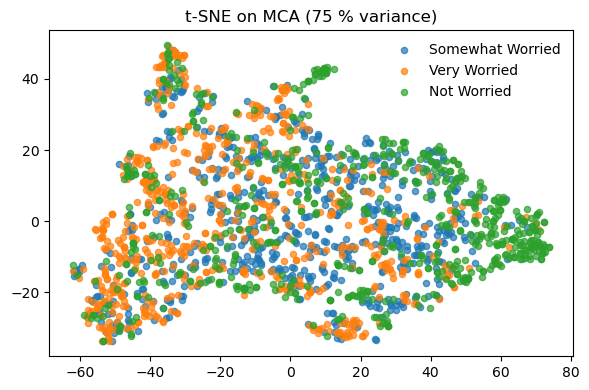

/opt/miniconda3/envs/ml_hw1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/ml_hw1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


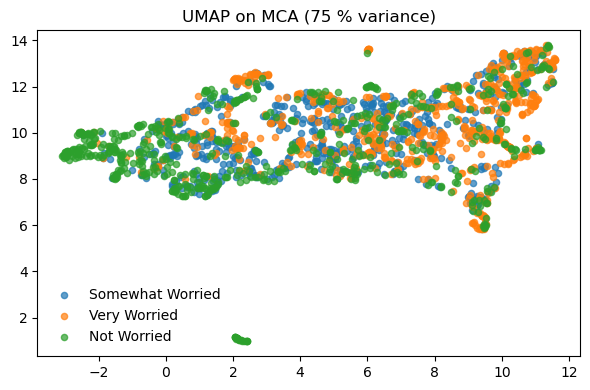

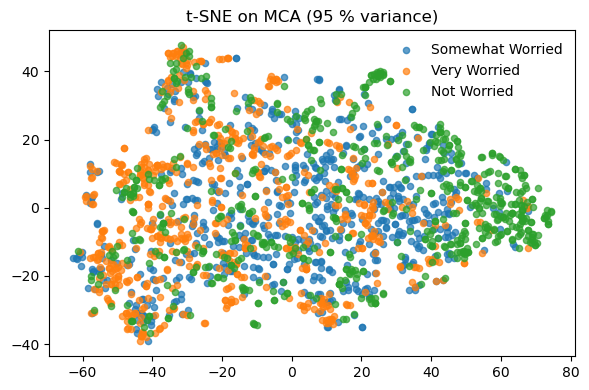

/opt/miniconda3/envs/ml_hw1/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/ml_hw1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


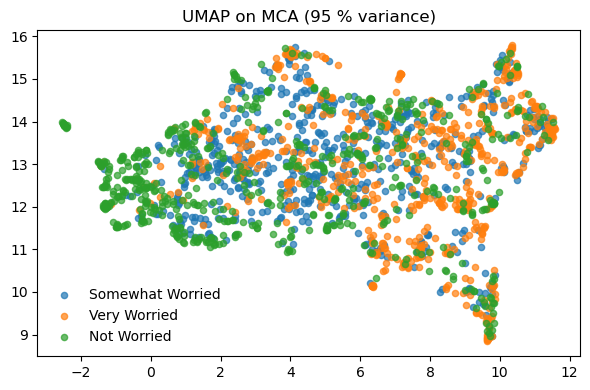

In [54]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap

df_75 = pd.read_csv('../data/mca_components_smote_75.csv')
df_95 = pd.read_csv('../data/mca_components_smote_95.csv')


features_75 = df_75
target_75   = smote['target']

features_95 = df_95
target_95   = smote['target']


# Mapping numeric code -> human‑readable label
label_map = {0: 'Somewhat Worried',
             1: 'Very Worried',
             2: 'Not Worried'}

# Consistent colours for the three classes
class_colors = {0: 'tab:blue',
                1: 'tab:orange',
                2: 'tab:green'}

def plot_embedding(X_emb, y, title):
    """Scatter each class separately so we can add a legend."""
    plt.figure(figsize=(6, 4))
    for cls in np.unique(y):
        idx = (y == cls)
        plt.scatter(X_emb[idx, 0],
                    X_emb[idx, 1],
                    c=class_colors[cls],
                    label=label_map[cls],
                    alpha=0.7,
                    s=20)
    plt.title(title)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 3.  t‑SNE & UMAP on the 75 % MCA set
# ------------------------------------------------------------
tsne_75 = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_75 = tsne_75.fit_transform(features_75)
plot_embedding(X_tsne_75, target_75,
               "t‑SNE on MCA (75 % variance)")

umap_75 = umap.UMAP(n_components=2, n_neighbors=15,
                    min_dist=0.1, random_state=42)
X_umap_75 = umap_75.fit_transform(features_75)
plot_embedding(X_umap_75, target_75,
               "UMAP on MCA (75 % variance)")

# ------------------------------------------------------------
# 4.  t‑SNE & UMAP on the 95 % MCA set
# ------------------------------------------------------------
tsne_95 = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_95 = tsne_95.fit_transform(features_95)
plot_embedding(X_tsne_95, target_95,
               "t‑SNE on MCA (95 % variance)")

umap_95 = umap.UMAP(n_components=2, n_neighbors=15,
                    min_dist=0.1, random_state=42)
X_umap_95 = umap_95.fit_transform(features_95)
plot_embedding(X_umap_95, target_95,
               "UMAP on MCA (95 % variance)")


In [55]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import umap.umap_ as umap

# # 1. Load the MCA datasets
# df_75 = pd.read_csv('../data/mca_components_smote_75.csv')
# df_95 = pd.read_csv('../data/mca_components_smote_95.csv')

# # ---------------------------------------------------------------------
# # If your target is non-numeric (e.g., strings), map or encode it here:
# # df_75['target'] = df_75['target'].map({'ClassA': 0, 'ClassB': 1, 'ClassC': 2})
# # df_95['target'] = df_95['target'].map({'ClassA': 0, 'ClassB': 1, 'ClassC': 2})
# # ---------------------------------------------------------------------

# # 2. Separate features from target (assuming 'target' is a column)
# features_75 = df_75
# target_75 = smote['target']

# features_95 = df_95
# target_95 = smote['target']

# # ================
# #    t-SNE 75%
# # ================
# tsne_75 = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne_75 = tsne_75.fit_transform(features_75)

# plt.scatter(X_tsne_75[:, 0], X_tsne_75[:, 1], c=target_75, alpha=0.7)
# plt.title("t-SNE on MCA (75% variance) - Colored by 3-class Target")
# plt.show()

# # ================
# #    t-SNE 95%
# # ================
# tsne_95 = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne_95 = tsne_95.fit_transform(features_95)

# plt.scatter(X_tsne_95[:, 0], X_tsne_95[:, 1], c=target_95, alpha=0.7)
# plt.title("t-SNE on MCA (95% variance) - Colored by 3-class Target")
# plt.show()

# # ===============
# #   UMAP 75%
# # ===============
# umap_reducer_75 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
# X_umap_75 = umap_reducer_75.fit_transform(features_75)

# plt.scatter(X_umap_75[:, 0], X_umap_75[:, 1], c=target_75, alpha=0.7)
# plt.title("UMAP on MCA (75% variance) - Colored by 3-class Target")
# plt.show()

# # ===============
# #   UMAP 95%
# # ===============
# umap_reducer_95 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
# X_umap_95 = umap_reducer_95.fit_transform(features_95)

# plt.scatter(X_umap_95[:, 0], X_umap_95[:, 1], c=target_95, alpha=0.7)
# plt.title("UMAP on MCA (95% variance) - Colored by 3-class Target")
# plt.show()


In [56]:
from sklearn.metrics import silhouette_score

score_tsne_75 = silhouette_score(X_tsne_75, target_75)
score_tsne_95 = silhouette_score(X_tsne_95, target_95)
score_umap_75 = silhouette_score(X_umap_75, target_75)
score_umap_95 = silhouette_score(X_umap_95, target_95)

print("t-SNE 75% Silhouette:", score_tsne_75)
print("t-SNE 95% Silhouette:", score_tsne_95)
print("UMAP 75% Silhouette:", score_umap_75)
print("UMAP 95% Silhouette:", score_umap_95)


t-SNE 75% Silhouette: -0.020310098
t-SNE 95% Silhouette: -0.017166788
UMAP 75% Silhouette: -0.023722922
UMAP 95% Silhouette: -0.019432196
